## Conditional effects and interactions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm


#please install bartpy by using the command:
# pip install git+https://github.com/JakeColtman/bartpy.git --upgrade
from bartpy.sklearnmodel import SklearnModel

#please install pymc3
# !pip install pymc3
import pymc3 as pm

In [2]:
#Import CSV File
AllData = pd.read_csv('AllViolenceData_171220.csv')
AllData.head()

,event_id,unix_timestamp,date,state_code,state,state_abbr,mun_code,municipality,detained,total_people_dead,...,army_lethality_diff,navy_lethality_diff,federal_police_lethality_diff,organized_crime_NewIndex,army_NewIndex,navy_NewIndex,federal_police_NewIndex,perfect_lethality,category,global_id
0,1.0,1168927210,2007-01-16,16,Michoacán de Ocampo,MICH,15,Coalcomán de Vázquez Pallares,0,1,...,0,0,0,1.0,NaN,NaN,NaN,1,perfect_lethality,1
1,2.0,1169013610,2007-01-17,16,Michoacán de Ocampo,MICH,15,Coalcomán de Vázquez Pallares,0,1,...,0,0,0,1.0,NaN,NaN,NaN,1,perfect_lethality,2
2,3.0,1170136810,2007-01-30,7,Chiapas,CHIS,65,Palenque,0,1,...,0,0,0,NaN,NaN,NaN,NaN,0,no_dead_wounded,3
3,4.0,1170396010,2007-02-02,15,México,MEX,81,Tecámac,2,0,...,0,-1,0,NaN,NaN,-1.0,NaN,0,no_dead_wounded,4
4,5.0,1170482410,2007-02-03,25,Sinaloa,SIN,6,Culiacán,0,1,...,0,0,0,1.0,NaN,NaN,NaN,1,perfect_lethality,5


### Conditional effects: a parametric perspective

From our long running sample dataset, we are seeking to answer two different questions: 

1. **are there more expected deaths when combat is heavier?**
2. **are there no expected deaths when no weapons are seized?**

We start by computing your full interactive model, including **all terms** that constitute the **interactions**. In this case, we're interested in evaluating the effects of long guns and cartridges on confrontations where each armed force participated. 


In [3]:
ols_interaction = sm.ols(data = AllData, formula = """organized_crime_dead ~ organized_crime_wounded + 
                                                    afi*long_guns_seized + army*long_guns_seized + 
                                                       navy*long_guns_seized + 
                                                    federal_police*long_guns_seized +
                                                    afi*cartridge_sezied + 
                                                       army*cartridge_sezied + 
                                                       navy*cartridge_sezied + 
                                                       federal_police*cartridge_sezied +
                                                       small_arms_seized + 
                                                       clips_seized""")
ols_interaction = ols_interaction.fit()
print(ols_interaction.summary())

                             OLS Regression Results                             
Dep. Variable:     organized_crime_dead   R-squared:                       0.159
Model:                              OLS   Adj. R-squared:                  0.156
Method:                   Least Squares   F-statistic:                     59.67
Date:                  Thu, 16 Apr 2020   Prob (F-statistic):          6.11e-187
Time:                          21:23:44   Log-Likelihood:                -10556.
No. Observations:                  5396   AIC:                         2.115e+04
Df Residuals:                      5378   BIC:                         2.127e+04
Df Model:                            17                                         
Covariance Type:              nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

As means of comparison this is how well this interactive model performs.

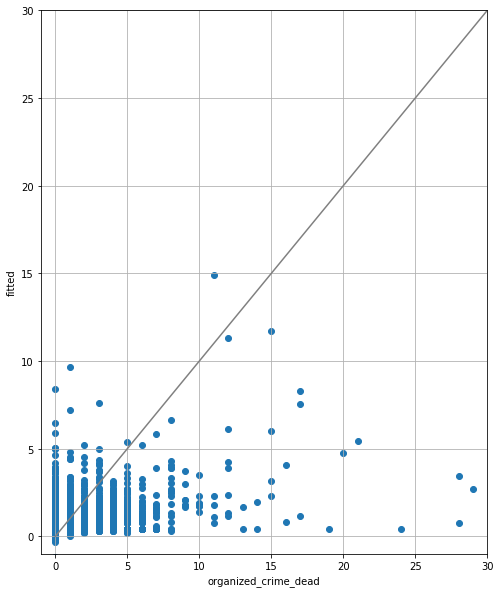

In [4]:
AllData['fitted'] = pd.Series(ols_interaction.fittedvalues) #add column of fitted values
ols_df = AllData[['organized_crime_dead', 'fitted']]

plt.figure(figsize=(8,10))
x = np.linspace(0,30)
plt.scatter('organized_crime_dead','fitted', data= ols_df)
plt.plot(x, x, '-r', label='y=x', color = 'grey')
plt.xlim(-1, 30)
plt.ylim(-1, 30)
plt.xlabel('organized_crime_dead')
plt.ylabel('fitted')
plt.grid()
plt.show()

![ols_fit-1.png](ols_fit-1.png 'ols_fit-1.png')



#### How do we compute interactive effects?

Looking at the coefficients of the interaction - such as `long_guns_seized:federal_police` is not sufficient to get the estimated interactive effects. You need to include all constitutive terms for the particular effect you seek to estimate.  

To do that, first, we need to extract the vector with the estimated coefficients from the model, as well as the the corresponding stantard errors from the estimated covariance matrix.

In [5]:
beta = ols_interaction.params                  # extracts a vector of betas -- coefficients
varcov = ols_interaction.cov_params().values   # extracts estimated covariance matrix
var = varcov.diagonal()                        # extracts a vector with variances

In [6]:
beta

Intercept                          0.418864
organized_crime_wounded            0.362405
afi                               -0.041927
long_guns_seized                   0.171381
afi:long_guns_seized               0.022901
army                               0.424445
army:long_guns_seized             -0.045957
navy                               0.277263
navy:long_guns_seized              0.176116
federal_police                    -0.111346
federal_police:long_guns_seized   -0.025381
cartridge_sezied                   0.000229
afi:cartridge_sezied              -0.005052
army:cartridge_sezied             -0.000391
navy:cartridge_sezied             -0.000691
federal_police:cartridge_sezied   -0.000152
small_arms_seized                 -0.045297
clips_seized                       0.000313
dtype: float64

In [7]:
var

array([1.13418396e-03, 5.65471641e-04, 2.54069972e-01, 2.96965467e-04,
       6.14710761e-03, 3.09528742e-03, 3.29069881e-04, 2.45743686e-02,
       1.77900180e-03, 6.42852744e-03, 3.63059870e-04, 9.37030288e-09,
       9.75370026e-06, 9.62411194e-09, 2.98662426e-08, 1.21554565e-08,
       3.46013712e-04, 9.89653302e-08])

#### Are there more expected deaths when combat is heavier?

To address the first question, we have to assume that a high number of long guns seized is a proxy for heavy combat. That is, we need to assume that it is more likely that more long guns are **used and seized** when heavy combat takes place. Therefore, we'll compute the marginal effect of 5 seized long guns on the expected number of dead on events that involve the Navy. 

We begin by defining an appropriate quantity for our conditioning variable `long_guns_seized`

In [8]:
long_guns = 5

Then, we use our known formula to compute the appropriate marginal effect: 

In [9]:
mfx_1 = beta['navy'] + (beta['navy:long_guns_seized']*long_guns)
mfx_1

1.1578425360536762

Similarly, we use our known formula to compute the appropriate standard errors, per the variance formula:

In [10]:
mfx_1_se = (var[7] + (long_guns**2)*var[8] +
           2*long_guns*varcov[7, 8])**0.5
mfx_1_se

0.21042872477937954

It is now easy to compute the lower and higher bounds of the marginal effect:

In [11]:
mfx_1_lo_se = mfx_1 - 1.96* mfx_1_se  # computing a lower bound se
mfx_1_hi_se = mfx_1 + 1.96* mfx_1_se  # computing the higher bound se

print(long_guns,"seized long guns increase the expected number of dead in events that involve the Navy by",
     round(mfx_1, 2), "[", round(mfx_1_lo_se, 2),",",round(mfx_1_hi_se, 2), "].")

5 seized long guns increase the expected number of dead in events that involve the Navy by 1.16 [ 0.75 , 1.57 ].


#### Are there no expected deaths when no weapons are seized?

To address the second question, we repeat the exercise and compute the marginal effect on the expected number of dead of events that involve the Army when no long guns (zero) are seized. This value is now assigned to our  conditioning variable `long_guns_seized`.

In [12]:
long_guns_null = 0

Again, we use our known formula to compute the appropriate marginal effect. Note that the second term is effectively dropped as the value of `long_guns_seized` is zero (0). 


In [13]:
mfx_2 = beta['army'] + beta['army:long_guns_seized']*long_guns_null
mfx_2

0.424445330218186

We compute the appropriate standard errors, per the variance formula, with the same caveat as above:

In [14]:
mfx_2_se = (var[5] + (long_guns_null**2)*var[6] + 2*long_guns_null*varcov[5,6])**0.5
mfx_2_se

0.055635307283242466

We can now compute the lower and higher bounds of the marginal effect:

In [15]:
mfx_2_lo_se = mfx_2 - 1.96* mfx_2_se  # computing a lower bound se
mfx_2_hi_se = mfx_2 + 1.96* mfx_2_se  # computing the higher bound se

print(long_guns_null, "seized long guns produce an expected number of dead in events that involve the Army of",
             round(mfx_2, 2), "[", round(mfx_2_lo_se, 2), ",", round(mfx_2_hi_se, 2),"]."
             )

0 seized long guns produce an expected number of dead in events that involve the Army of 0.42 [ 0.32 , 0.53 ].


### Conditional effects: a non-parametric perspective

From a different perspective, we try to quantify conditional effects but using predicted values using predictions from a **Bayesian Additive Regression Trees** (BART) model.

For this specific purpose, we train BART on all of our data (no test or validation sets), and separate only the Y vector from all of our predictors to create two matrices. Note that we need to pass the data frame through a processing function (`bartModelMatrix()`) so that it can be read seamlessly. 

In [4]:
# target variable for training
y_train = AllData['organized_crime_dead'].values


# predictors to be re-used for multiple predictions
x_train_base = AllData[['organized_crime_wounded', 'afi', 'army', 'navy', 'federal_police', 
     'long_guns_seized', 'small_arms_seized', 'clips_seized', 
     'cartridge_sezied', 'organized_crime_dead']]

# explanatory variables for training
x_train = np.asmatrix(x_train_base)

#### fitting BART and diagnostics

BART needs little tuning and usually works well with default settings for `m = 200` and default priors for other parameters. 


In [95]:
# fitting bart on the training data
model = SklearnModel()
bart_fit = model.fit(x_train_base, y_train)

(5396,)

Once fit, we diagnose the model. Note how well BART fits the observed data. Compared to the fit of the OLS interactive model, it is quite an improvement due to BART's ability to capture non-linearities and interactions. 

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(y_train, bart_fit.predict(x_train_base))
plt.xlabel('y_train')
plt.ylabel('bart_fit$yhat.train.mean')

![fit_observed-1.png](fit_observed-1.png 'fit_observed-1.png')

A different view of the plot above, confirms the same pattern: most errors produced by BART are very small and concentrated very close to zero. 


In [ ]:
plt.figure(figsize=(8,8))
plt.hist(y_train - bart_fit.predict(x_train_base))
plt.title("Histogram of y_train - bart_fit$yhat.train.mean")

![unnamed-chunk-13.png](unnamed-chunk-13-1.png 'unnamed-chunk-13-1.png')

#### how do we compute marginal effects?

To compute the marginal effects, we can use the predictive posterior generated by fitting BART to all our data and create predictions changing the values of specific predictors to values of interest. In our case, we are interested in the change in the expected number of `organized_crime_dead` given a specific number of `long_guns_seized` (say, between 0 and 20) for events where the navy participated (`navy == 1`). 

To do that, we must:

1. create a new `x_train` matrix where all values of `navy` are set to `1` and `long_guns_seized` to a specific value between 0 and 20, maintaining the values of all other predictors unchanged
2. use this new `x_train` matrix and BART's predictive posterior to generate synthetic values for each combination of `navy` and `long_guns_seized`
3. this produces a new `y_test` matrix that summarizes `L = 1000` simulatons for ach of our `N = 5396` events, which we summarize by averaging over `N` to get a single `M x 1` vector of synthetic values for eacg combinations of values we are iterating over
4. we collect those vectors in a matrix of simulations with 21 columns for eacg value of `long_guns_seized` we are allowing to change

Through this process, we hold the value of `navy` constant at `1` and conditional on that value, we iterate through values for `long_guns_seized` giving us an equivalent view of the conditional effects we are seeking to evaluate.

In [107]:
x_test = x_train.copy()
x_test['navy'] = 1

n = 1000
synth_vals= np.zeros((n, 21))
for i in range(21): 
    x_test['long_guns_seized'] = i
    print("synthetic values for long guns seized == ", i)
    
    # creating synthetic values from the predictive posterior

    with pm.Model() as model_g:
        μ = pm.Uniform('μ', lower=0, upper=29)
        σ = pm.HalfNormal('σ', sd=10)
        y = pm.Normal('y', mu=μ, sd=σ, observed=bart_fit.predict(x_test)) #this gives the predicted y's
        trace_g = pm.sample(1000, tune=1000)

    # create prediction matrices
    ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model=model_g)
    a = np.asarray(ppc['y'])
    bart_post = np.asmatrix(a) 
    
    ## store synthetic values in a matrix
    new = np.apply_along_axis(np.mean, 1, bart_post) # 1 is the row; repeating
    #this is n rows and 1 column
    synth_vals[:, i] = new

synthetic values for long guns seized ==  0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1093.05draws/s]
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 714.72it/s]


synthetic values for long guns seized ==  1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1147.38draws/s]
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 699.38it/s]


synthetic values for long guns seized ==  2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 717.31draws/s] 
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:02<00:00, 494.99it/s]


synthetic values for long guns seized ==  3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 939.32draws/s] 
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 715.31it/s]


synthetic values for long guns seized ==  4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 956.75draws/s] 
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 654.13it/s]


synthetic values for long guns seized ==  5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 975.26draws/s] 
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 694.77it/s]


synthetic values for long guns seized ==  6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 973.77draws/s] 
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 700.78it/s]


synthetic values for long guns seized ==  7


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 854.14draws/s] 
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 673.30it/s]


synthetic values for long guns seized ==  8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 700.83draws/s]
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 524.56it/s]


synthetic values for long guns seized ==  9


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 850.84draws/s] 
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 575.54it/s]


synthetic values for long guns seized ==  10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 971.79draws/s] 
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 670.13it/s]


synthetic values for long guns seized ==  11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 843.55draws/s] 
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 542.10it/s]


synthetic values for long guns seized ==  12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1136.81draws/s]
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 733.96it/s]


synthetic values for long guns seized ==  13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 891.24draws/s] 
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 710.89it/s]


synthetic values for long guns seized ==  14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1096.71draws/s]
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 693.10it/s]


synthetic values for long guns seized ==  15


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 748.83draws/s] 
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 715.21it/s]


synthetic values for long guns seized ==  16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1143.45draws/s]
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 711.83it/s]


synthetic values for long guns seized ==  17


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 931.14draws/s] 
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:02<00:00, 491.50it/s]


synthetic values for long guns seized ==  18


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1054.59draws/s]
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 677.44it/s]


synthetic values for long guns seized ==  19


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 723.15draws/s] 
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 587.72it/s]


synthetic values for long guns seized ==  20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 799.96draws/s] 
/Users/ryan/anaconda3/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 695.91it/s]


In [110]:
synth_vals

array([[0.77734088, 0.85707077, 0.83715353, ..., 0.8548739 , 0.85396474,
        0.83949778],
       [0.88182095, 0.88253912, 0.87239719, ..., 0.84580355, 0.8575846 ,
        0.88665266],
       [0.88031033, 0.80290131, 0.90038666, ..., 0.78570517, 0.8488702 ,
        0.83297051],
       ...,
       [0.81233208, 0.79371283, 0.79992061, ..., 0.86181146, 0.88373467,
        0.89242117],
       [0.77367873, 0.84101932, 0.83927048, ..., 0.8831258 , 0.79239947,
        0.85870082],
       [0.78634335, 0.92991793, 0.85344569, ..., 0.81146095, 0.89893703,
        0.82466629]])

In [111]:
synth_vals.shape

(1000, 21)

The matrix gives a information not only about expected values but also about their uncertainty. We can summarize it to construct an initial view of expected values of `organized_crime_dead` conditional on events where the `navy` participates and specific numbers of `long_guns_seized`.

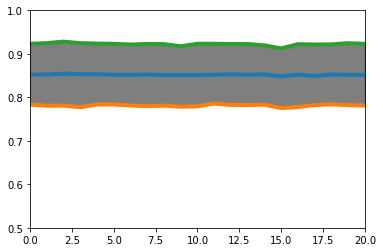

In [139]:
guns = pd.Series(range(21), name = 'guns')
mean_vals = pd.Series(np.apply_along_axis(np.mean, 0, synth_vals), name = "mean_vals")
lo_ci = pd.Series(np.apply_along_axis(np.quantile, 0, synth_vals, q = 0.025), name = "lo_ci")
hi_ci = pd.Series(np.apply_along_axis(np.quantile, 0, synth_vals, q = 0.975), name = "hi_ci")



#Plot
plt.figure(figsize=(8,8))
plt.plot(guns,mean_vals,lw=4)
plt.plot(guns,lo_ci,lw=4)
plt.plot(guns,hi_ci,lw=4)

plt.ylim(0.5,1)

plt.fill_between(guns, mean_vals, lo_ci, color = 'k', alpha = .5)
plt.fill_between(guns, mean_vals, hi_ci, color = 'k', alpha= .5)

plt.xlim(0, 20)
ax.set_xlabel('long_guns_seized')
ax.set_ylabel('expected organized crime deaths')
ax.grid()

![synthetics-1.png](synthetics-1.png 'synthetics-1.png')

To get a comparable estimate to the marginal effect on the **parametric perspective** where we want to quantify the marginal effect of having 5 `long_guns_seized` on the expected number of `organized_crime_dead` in events that involve the `navy`, we can compute the difference between the expected number of `organized_crime_dead` when 4 and 5 `long_guns_seized` exist for events that involve the `navy` and its associated uncertainty. 

To do that we simply subtract columns for `organized_crime_dead == 4` from the column `organized_crime_dead == 5` in the matrix above, and summarize its mean value and 95% credible intervals. 

You'll note how small that contibution is:

In [124]:
print("{:.9f}".format(np.mean(synth_vals[:, 0] - synth_vals[:, 1])))


0.000000000


In [117]:
print("{:.9f}".format(np.quantile((synth_vals[:, 6] - synth_vals[:, 5]), q = 0.025)))

-0.107081714


In [118]:
print("{:.9f}".format(np.quantile((synth_vals[:, 6] - synth_vals[:, 5]), q = 0.9725)))

0.091194164
